<a href="https://colab.research.google.com/github/Abishethvarman/FakeNewsDetection/blob/sentiment-analysis/V1_6_Sentiment_Analysis_roBERTa_FakeNews_Full_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Sentiment Analysis on Roberta referring https://www.youtube.com/watch?v=QpzMWQvxXWk and https://www.kaggle.com/code/robikscube/sentiment-analysis-python-youtube-tutorial/notebook

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import nltk
import gensim
import plotly.express as px

from tqdm import tqdm
from tqdm.notebook import tqdm
from nltk.corpus import stopwords
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.sentiment import SentimentIntensityAnalyzer
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax
from nltk.tokenize import word_tokenize
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report


nltk.download('stopwords')
nltk.download('punkt')
nltk.download('vader_lexicon')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
plt.style.use('ggplot')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

!ln -s /content/gdrive/My\ Drive/ /mydrive
!ls /mydrive

In [5]:
%cd /mydrive/dataset/

/content/gdrive/My Drive/dataset


In [6]:
df=pd.read_csv("fake-20000-SA.csv")

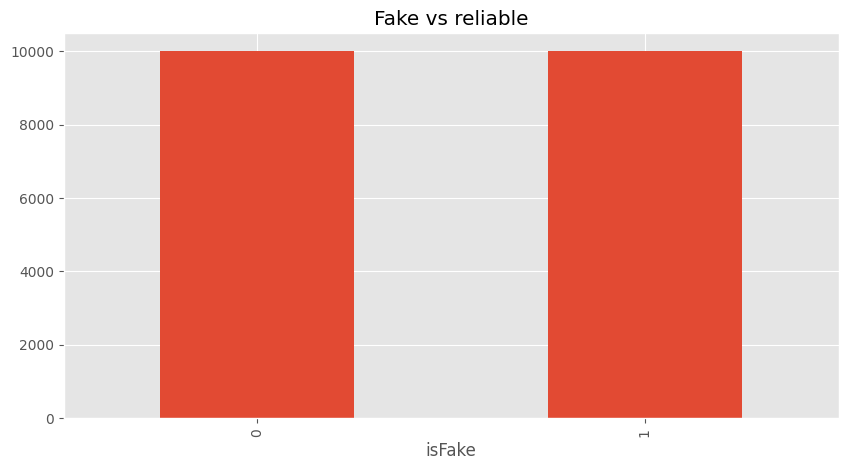

In [7]:
ax = df['isfake'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Fake vs reliable',
          figsize=(10, 5))
ax.set_xlabel('isFake')
plt.show()

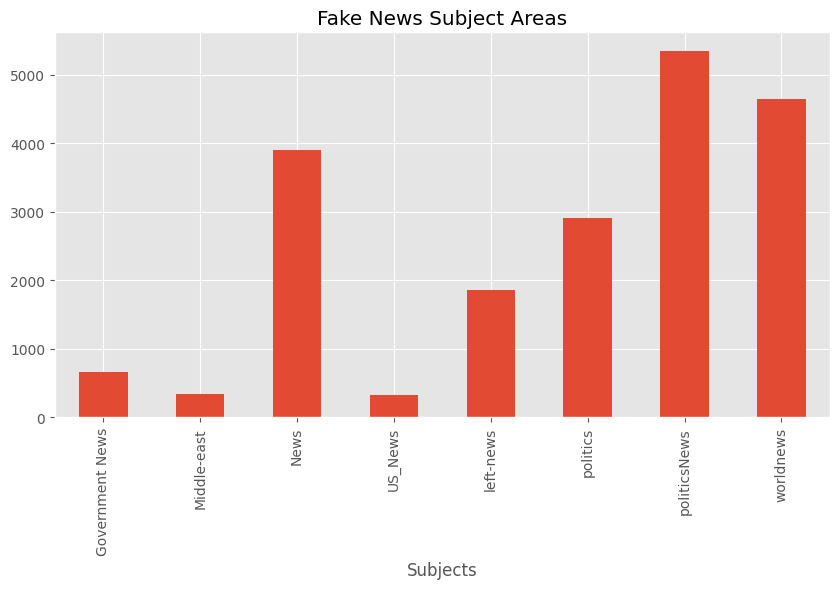

In [8]:
ax = df['subject'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Fake News Subject Areas',
          figsize=(10, 5))
ax.set_xlabel('Subjects')
plt.show()

In [9]:
df['original'] = df['title'] + ' ' + df['text']
df.head()

,Unnamed: 0,title,text,subject,date,isfake,label,original
0,10650,Trump Supporters Terrorize An American Woman ...,Donald Trump s deplorable supporters strike ag...,News,"December 3, 2016",1,fake,Trump Supporters Terrorize An American Woman ...
1,2041,Trump adviser's Russia credentials come under ...,MOSCOW (Reuters) - When Donald Trump named a l...,politicsNews,"August 24, 2016",0,real,Trump adviser's Russia credentials come under ...
2,8668,Turkey feels betrayed over EU accession but st...,LONDON (Reuters) - Turkey feels betrayed by so...,worldnews,"September 14, 2017",0,real,Turkey feels betrayed over EU accession but st...
3,1114,China newspapers say call with Taiwan's Tsai s...,SHANGHAI (Reuters) - Chinese state media on Mo...,politicsNews,"December 5, 2016",0,real,China newspapers say call with Taiwan's Tsai s...
4,13902,Sean Hannity Just Openly Threatened Someone O...,Is there some reason people like Donald Trump ...,News,"April 30, 2017",1,fake,Sean Hannity Just Openly Threatened Someone O...


In [10]:
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'one', 'two', 'more','said','u','however','still','get','many','could'])

In [11]:
from gensim.parsing.preprocessing import STOPWORDS, remove_stopword_tokens
def preprocess(text):
    words = word_tokenize(text)
    filtered_words = [word for word in words if word.lower() not in stop_words and word.lower() != 'mor']
    return ' '.join(filtered_words)

In [12]:
# Apply the function to the dataframe
df['clean'] = df['original'].apply(preprocess)

In [13]:
print(df['clean'][0])

Trump Supporters Terrorize American Woman Subway Wearing Hijab Donald Trump deplorable supporters strike again.18-year-old Yasmin Seweid born Brooklyn , New York . raised America entire life . grew surrounded American culture values religious freedom guaranteed Constitution.And able wear hijab practice Islam.But standing subway platform waiting go home , three male Trump supporters targeted began harassing . called terrorist , ripped straps bag , tried forcibly remove hijab saying Trump name.The abuse continued train Seweid forced exit early stop order away . Bystanders even watched incident unfold cowardly nothing stop it.She reported incident police , investigating crime.In order warn others dangers Trump supporters , Seweid chose write horrific experience Facebook . take train every single day going & coming class , yesterday , something happened never thought would happen , Seweid wrote . harassed subway last night dehumanizing speak without getting emotional . Three white racists 

In [14]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [15]:
df['id'] = df.index + 1

In [16]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [18]:
res_roberta = {}
batch_size = 5
max_position_embeddings = model.config.max_position_embeddings
max_length = min(514, max_position_embeddings)

subset_size = 2000
for batch_start in tqdm(range(0, subset_size, batch_size)):
    batch_df = df.iloc[batch_start:batch_start + batch_size]

    for i, row in batch_df.iterrows():
        try:
            text = row['clean']
            myid = row['id']

            if not text or len(text) < 3:
                print(f'Skipping empty or very short text for id {myid}')
                continue

            # Manually encode the text with max_length
            tokenized_text = tokenizer.encode(text, max_length=max_length, truncation=True)

            # Pad the sequence to the maximum length
            padded_text = tokenized_text + [tokenizer.pad_token_id] * (max_length - len(tokenized_text))

            # Convert the padded_text to a tensor
            input_ids = torch.tensor(padded_text).unsqueeze(0)  # Add batch dimension

            # Generate attention_mask tensor
            attention_mask = (input_ids != tokenizer.pad_token_id).long()

            # Generate position_ids tensor
            position_ids = torch.arange(0, max_length).unsqueeze(0).expand_as(input_ids)

            # Pass the input_ids, position_ids, and attention_mask tensors to the RoBERTa model
            outputs = model(input_ids, position_ids=position_ids, attention_mask=attention_mask)

            # Perform RoBERTa sentiment analysis
            roberta_result = polarity_scores_roberta(text)

            res_roberta[myid] = roberta_result

        except RuntimeError as e:
            print(f'Broke for id {myid}: {e}')
        except IndexError as e:
            print(f'Index error for id {myid}: {e}')


  0%|          | 0/400 [00:00<?, ?it/s]

Broke for id 2: The expanded size of the tensor (1025) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 1025].  Tensor sizes: [1, 514]
Broke for id 4: The expanded size of the tensor (535) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 535].  Tensor sizes: [1, 514]
Broke for id 9: The expanded size of the tensor (634) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 634].  Tensor sizes: [1, 514]
Broke for id 11: The expanded size of the tensor (623) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 623].  Tensor sizes: [1, 514]
Broke for id 13: The expanded size of the tensor (515) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 515].  Tensor sizes: [1, 514]
Broke for id 21: The expanded size of the tensor (765) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 765].  Tensor siz

In [19]:
df

,Unnamed: 0,title,text,subject,date,isfake,label,original,clean,id
0,10650,Trump Supporters Terrorize An American Woman ...,Donald Trump s deplorable supporters strike ag...,News,"December 3, 2016",1,fake,Trump Supporters Terrorize An American Woman ...,Trump Supporters Terrorize American Woman Subw...,1
1,2041,Trump adviser's Russia credentials come under ...,MOSCOW (Reuters) - When Donald Trump named a l...,politicsNews,"August 24, 2016",0,real,Trump adviser's Russia credentials come under ...,Trump adviser 's Russia credentials come scrut...,2
2,8668,Turkey feels betrayed over EU accession but st...,LONDON (Reuters) - Turkey feels betrayed by so...,worldnews,"September 14, 2017",0,real,Turkey feels betrayed over EU accession but st...,Turkey feels betrayed EU accession wants join ...,3
3,1114,China newspapers say call with Taiwan's Tsai s...,SHANGHAI (Reuters) - Chinese state media on Mo...,politicsNews,"December 5, 2016",0,real,China newspapers say call with Taiwan's Tsai s...,China newspapers say call Taiwan 's Tsai shows...,4
4,13902,Sean Hannity Just Openly Threatened Someone O...,Is there some reason people like Donald Trump ...,News,"April 30, 2017",1,fake,Sean Hannity Just Openly Threatened Someone O...,Sean Hannity Openly Threatened Someone Twitter...,5
...,...,...,...,...,...,...,...,...,...,...
19995,11284,RUSSIAN AMBASSADOR Visited Obama 6 Times Durin...,FLASHBACK: HILLARY CLINTON S STATE DEPARTMENT ...,politics,"Mar 3, 2017",1,fake,RUSSIAN AMBASSADOR Visited Obama 6 Times Durin...,RUSSIAN AMBASSADOR Visited Obama 6 Times Hilla...,19996
19996,11964,MAJOR Ad Vendor Bans Breitbart For Hate Speec...,You know how Donald Trump has been trying to c...,News,"November 22, 2016",1,fake,MAJOR Ad Vendor Bans Breitbart For Hate Speec...,"MAJOR Ad Vendor Bans Breitbart Hate Speech , T...",19997
19997,5390,Jordan begins diplomatic offensive ahead of Tr...,AMMAN (Reuters) - Jordan has begun consultatio...,worldnews,"December 3, 2017",0,real,Jordan begins diplomatic offensive ahead of Tr...,Jordan begins diplomatic offensive ahead Trump...,19998
19998,860,U.S.-Russia tensions over Syria will not 'spir...,WASHINGTON (Reuters) - Tensions between the Un...,politicsNews,"April 11, 2017",0,real,U.S.-Russia tensions over Syria will not 'spir...,U.S.-Russia tensions Syria 'spiral control ' :...,19999


In [25]:
batch_df.head(10)

,Unnamed: 0,title,text,subject,date,isfake,label,original,clean,id
1995,5022,Britain must be clearer on Brexit divorce bill...,BRUSSELS (Reuters) - British Prime Minister Th...,worldnews,"October 19, 2017",0,real,Britain must be clearer on Brexit divorce bill...,Britain must clearer Brexit divorce bill : Dut...,1996
1996,10013,Colbert Grills Sanders On His ‘Revolution For...,Senator Bernie Sanders made an appearance on T...,News,"February 11, 2016",1,fake,Colbert Grills Sanders On His ‘Revolution For...,Colbert Grills Sanders ‘ Revolution America ’ ...,1997
1997,13927,Blood Sport: GOP Presidential Race Takes Anoth...,Patrick Henningsen 21st Century WireAs Baron R...,Middle-east,"February 26, 2016",1,fake,Blood Sport: GOP Presidential Race Takes Anoth...,Blood Sport : GOP Presidential Race Takes Anot...,1998
1998,9560,Germany suspends training of Kurdish fighters ...,BERLIN (Reuters) - Germany will suspend its mi...,worldnews,"October 18, 2017",0,real,Germany suspends training of Kurdish fighters ...,Germany suspends training Kurdish fighters nor...,1999
1999,17323,JUDGE JEANINE ON JAMES COMEY: “He’s a predator...,Judge Jeanine commented this morning on the FB...,politics,"Jun 9, 2017",1,fake,JUDGE JEANINE ON JAMES COMEY: “He’s a predator...,JUDGE JEANINE JAMES COMEY : “ ’ predator ! ” [...,2000


In [26]:
res_roberta

{1: {'roberta_neg': 0.9307487,
  'roberta_neu': 0.06499957,
  'roberta_pos': 0.0042517874},
 3: {'roberta_neg': 0.6503101,
  'roberta_neu': 0.33519742,
  'roberta_pos': 0.014492532},
 5: {'roberta_neg': 0.5067015,
  'roberta_neu': 0.45078397,
  'roberta_pos': 0.042514525},
 6: {'roberta_neg': 0.8586863,
  'roberta_neu': 0.13248296,
  'roberta_pos': 0.00883065},
 7: {'roberta_neg': 0.10866813,
  'roberta_neu': 0.5970076,
  'roberta_pos': 0.29432428},
 8: {'roberta_neg': 0.6709513,
  'roberta_neu': 0.31107125,
  'roberta_pos': 0.017977452},
 10: {'roberta_neg': 0.46817484,
  'roberta_neu': 0.49513957,
  'roberta_pos': 0.036685646},
 12: {'roberta_neg': 0.49628288,
  'roberta_neu': 0.4741711,
  'roberta_pos': 0.029546013},
 14: {'roberta_neg': 0.55378157,
  'roberta_neu': 0.4244498,
  'roberta_pos': 0.021768607},
 15: {'roberta_neg': 0.5295334,
  'roberta_neu': 0.4317698,
  'roberta_pos': 0.038696848},
 16: {'roberta_neg': 0.47928795,
  'roberta_neu': 0.4982016,
  'roberta_pos': 0.0225104

In [28]:
sentiment_df = pd.DataFrame(columns=['id', 'roberta_neg', 'roberta_neu', 'roberta_pos'])

for batch_start in tqdm(range(0, subset_size, batch_size)):
    batch_df = df.iloc[batch_start:batch_start + batch_size]

    for i, row in batch_df.iterrows():
        try:
            text = row['clean']
            myid = row['id']

            if not text or len(text) < 3:
                print(f'Skipping empty or very short text for id {myid}')
                continue

            # Manually encode the text with max_length
            tokenized_text = tokenizer.encode(text, max_length=max_length, truncation=True)

            # Pad the sequence to the maximum length
            padded_text = tokenized_text + [tokenizer.pad_token_id] * (max_length - len(tokenized_text))

            # Convert the padded_text to a tensor
            input_ids = torch.tensor(padded_text).unsqueeze(0)  # Add batch dimension

            # Generate attention_mask tensor
            attention_mask = (input_ids != tokenizer.pad_token_id).long()

            # Generate position_ids tensor
            position_ids = torch.arange(0, max_length).unsqueeze(0).expand_as(input_ids)

            # Pass the input_ids, position_ids, and attention_mask tensors to the RoBERTa model
            outputs = model(input_ids, position_ids=position_ids, attention_mask=attention_mask)

            # Perform RoBERTa sentiment analysis
            roberta_result = polarity_scores_roberta(text)

            # Store the results in the sentiment_df DataFrame
            sentiment_df = sentiment_df.append({
                'id': myid,
                'roberta_neg': roberta_result['roberta_neg'],
                'roberta_neu': roberta_result['roberta_neu'],
                'roberta_pos': roberta_result['roberta_pos']
            }, ignore_index=True)

        except RuntimeError as e:
            print(f'Broke for id {myid}')
        except IndexError as e:
            print(f'Index error for id {myid}')

# Merge sentiment_df with the original DataFrame based on the 'id' column
df = pd.merge(df, sentiment_df, on='id', how='left')


  0%|          | 0/400 [00:00<?, ?it/s]

<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({


Broke for id 2


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({


Broke for id 4


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({


Broke for id 9


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({


Broke for id 11


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({


Broke for id 13


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

Broke for id 21


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

Broke for id 28


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({


Broke for id 30


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({


Broke for id 33


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

Broke for id 40


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

Broke for id 48


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({


Broke for id 50


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({


Broke for id 52


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({


Broke for id 57


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

Broke for id 63


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({


Broke for id 68


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({


Broke for id 72


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

Broke for id 78


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

Broke for id 95


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

Broke for id 102


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({


Broke for id 107


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

Broke for id 123


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

Broke for id 133


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({


Broke for id 135


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({


Broke for id 138
Broke for id 139


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

Broke for id 145


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({


Broke for id 149


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({


Broke for id 152


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({


Broke for id 154


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({


Broke for id 156


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

Broke for id 162


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({


Broke for id 166


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({


Broke for id 170


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({


Broke for id 175


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({


Broke for id 177


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({


Broke for id 182


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({


Broke for id 186


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

Broke for id 195


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({


Broke for id 200


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

Broke for id 209
Broke for id 210
Broke for id 211


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({


Broke for id 214


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

Broke for id 223


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({


Broke for id 226
Broke for id 227
Broke for id 228
Index error for id 229


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({


Broke for id 231


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

Broke for id 239


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({


Broke for id 242


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({


Broke for id 245


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

Broke for id 253


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

Broke for id 261


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({


Broke for id 263


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

Broke for id 273


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({


Broke for id 278
Broke for id 279


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({


Broke for id 283


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({


Broke for id 285


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({


Broke for id 288


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({


Broke for id 292


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

Broke for id 301
Broke for id 302


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

Broke for id 310
Broke for id 311


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({


Broke for id 313
Broke for id 314


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({


Broke for id 319
Broke for id 320


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

Broke for id 341


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

Index error for id 348


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({


Broke for id 351
Broke for id 352


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

Broke for id 363


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

Broke for id 372
Broke for id 373
Broke for id 374


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

Broke for id 399


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

Broke for id 411


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

Broke for id 418


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({


Broke for id 423


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

Broke for id 429


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

Broke for id 438


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

Broke for id 445


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({


Broke for id 450


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({


Broke for id 452


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({


Broke for id 454


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

Broke for id 461


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({


Broke for id 463


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

Broke for id 476


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({


Broke for id 479


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

Broke for id 486


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({


Broke for id 490


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({


Broke for id 494


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({


Broke for id 497
Broke for id 498


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({


Broke for id 500


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

Broke for id 512


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

Broke for id 523


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

Broke for id 533
Broke for id 534


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({


Broke for id 536


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({


Broke for id 540


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({


Broke for id 543


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

Broke for id 552


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

Broke for id 563


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({


Broke for id 567


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({


Broke for id 569


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

Broke for id 578


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

Broke for id 591


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

Broke for id 598


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

Broke for id 607


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({


Broke for id 609


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({


Broke for id 611


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

Broke for id 630


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

Broke for id 638


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({


Broke for id 642


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({


Broke for id 647


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

Broke for id 654


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

Broke for id 663
Broke for id 664


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({


Broke for id 668


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({


Broke for id 670


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

Broke for id 676


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

Broke for id 690


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({


Broke for id 694


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({


Broke for id 697


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({


Broke for id 702


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

Broke for id 709


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({


Broke for id 712


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({


Broke for id 716


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

Broke for id 722


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({


Broke for id 727


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({


Broke for id 731
Broke for id 732


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({


Broke for id 735
Broke for id 736
Broke for id 737
Broke for id 738


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({


Broke for id 741


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({


Broke for id 745


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({


Broke for id 749


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({


Broke for id 753


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

Broke for id 769


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({


Broke for id 772


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

Broke for id 779
Broke for id 780


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({


Broke for id 783


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

Broke for id 792


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({


Broke for id 795


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({


Broke for id 798


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

Broke for id 808


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({


Broke for id 811


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({


Broke for id 813


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

Broke for id 827
Broke for id 828


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({


Broke for id 832


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

Broke for id 839
Broke for id 840


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({


Broke for id 843


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

Broke for id 854
Broke for id 855


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({


Broke for id 860


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({


Broke for id 865


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

Broke for id 884


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({


Broke for id 886


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

Broke for id 898


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

Broke for id 914


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

Broke for id 928


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({


Broke for id 931


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({


Broke for id 934


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({


Broke for id 938


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({


Broke for id 943


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({


Broke for id 947


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({


Broke for id 952


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({


Broke for id 957


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

Broke for id 963


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({


Broke for id 965
Broke for id 966


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({


Broke for id 968
Broke for id 969


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

Broke for id 975


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({


Broke for id 980


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

Broke for id 990


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({


Broke for id 993
Broke for id 994


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

Broke for id 1012


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({


Broke for id 1014


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({


Broke for id 1017


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({


Broke for id 1020


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({


Broke for id 1023


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

Broke for id 1029


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({


Broke for id 1032
Broke for id 1033


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

Broke for id 1042


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

Broke for id 1048


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({


Broke for id 1051
Broke for id 1052


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

Broke for id 1060


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

Broke for id 1066
Broke for id 1067
Broke for id 1068


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({


Broke for id 1070


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({


Broke for id 1072


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({


Broke for id 1075


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({


Broke for id 1078


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

Broke for id 1097


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

Broke for id 1105


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({


Broke for id 1108
Broke for id 1109


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({


Broke for id 1112
Broke for id 1113
Broke for id 1114
Broke for id 1115


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

Broke for id 1121


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

Broke for id 1143
Broke for id 1144
Broke for id 1145


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

Broke for id 1157


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

Broke for id 1180


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({


Broke for id 1184
Broke for id 1185


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({


Broke for id 1189


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({


Broke for id 1192


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

Broke for id 1198


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({


Broke for id 1202


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({


Broke for id 1207


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({


Broke for id 1212


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({


Broke for id 1215


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

Broke for id 1221


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

Broke for id 1238
Broke for id 1239


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({


Broke for id 1244


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

Broke for id 1250


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({


Broke for id 1253


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({


Broke for id 1256


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

Broke for id 1264


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({


Broke for id 1268


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

Broke for id 1275


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

Broke for id 1281


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

Broke for id 1313


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({


Broke for id 1317


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({


Broke for id 1319


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

Broke for id 1325


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({


Broke for id 1329


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({


Broke for id 1332
Broke for id 1333


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({


Broke for id 1335


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({


Broke for id 1338


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

Broke for id 1344


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({


Broke for id 1346


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({


Broke for id 1348


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({


Broke for id 1353


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({


Broke for id 1355


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({


Broke for id 1359


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({


Broke for id 1363


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({


Broke for id 1366


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({


Broke for id 1368


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

Broke for id 1388


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({


Broke for id 1392


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({


Broke for id 1397


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

Broke for id 1404


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

Broke for id 1415


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

Broke for id 1435


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({


Broke for id 1440


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

Broke for id 1446


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({


Broke for id 1449


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({


Broke for id 1453


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

Broke for id 1465


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

Broke for id 1475


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

Broke for id 1484


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

Broke for id 1491
Broke for id 1492


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

Broke for id 1501


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

Broke for id 1519


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({


Broke for id 1524


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({


Broke for id 1526


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({


Broke for id 1529


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

Broke for id 1535


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({


Broke for id 1540


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({


Broke for id 1543


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({


Broke for id 1546


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({


Broke for id 1550


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

Broke for id 1556


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({


Broke for id 1558


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

Broke for id 1564
Broke for id 1565
Broke for id 1566


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

Broke for id 1573


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

Broke for id 1581


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({


Broke for id 1583
Broke for id 1584


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

Broke for id 1596


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({


Broke for id 1599


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

Broke for id 1605


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

Broke for id 1613


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

Broke for id 1621


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({


Broke for id 1625


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({


Broke for id 1627


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({


Broke for id 1632
Broke for id 1633


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

Broke for id 1639


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({


Broke for id 1643


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

Broke for id 1653


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({


Broke for id 1655


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

Broke for id 1665


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

Broke for id 1683


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({


Broke for id 1685
Broke for id 1686


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

Broke for id 1701


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({


Broke for id 1703


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({


Broke for id 1707


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({


Broke for id 1710


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({


Broke for id 1715
Broke for id 1716


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({


Broke for id 1719
Broke for id 1720


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

Broke for id 1738


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({


Broke for id 1740


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({


Broke for id 1745


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

Broke for id 1755


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

Broke for id 1763


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

Broke for id 1777


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

Broke for id 1785


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({


Broke for id 1788
Broke for id 1789


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

Broke for id 1802


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

Broke for id 1811


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({


Broke for id 1816
Broke for id 1817


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

Broke for id 1824
Broke for id 1825


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({


Broke for id 1828


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({


Broke for id 1832


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({


Broke for id 1835


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({


Broke for id 1837
Broke for id 1838
Broke for id 1839


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

Broke for id 1845
Broke for id 1846


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

Broke for id 1854


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

Broke for id 1862


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({


Broke for id 1865


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({


Broke for id 1868


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

Broke for id 1894
Broke for id 1895


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

Broke for id 1911


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

Broke for id 1920


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({


Broke for id 1925
Broke for id 1926


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({


Broke for id 1928


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

Broke for id 1935


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({


Broke for id 1938


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({


Broke for id 1941


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({


Broke for id 1943


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

Broke for id 1962


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

Broke for id 1972


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

Broke for id 1992


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

Broke for id 1998


<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({
<ipython-input-28-ab3151684488>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_df = sentiment_df.append({


In [29]:
df

,Unnamed: 0,title,text,subject,date,isfake,label,original,clean,id,roberta_neg,roberta_neu,roberta_pos
0,10650,Trump Supporters Terrorize An American Woman ...,Donald Trump s deplorable supporters strike ag...,News,"December 3, 2016",1,fake,Trump Supporters Terrorize An American Woman ...,Trump Supporters Terrorize American Woman Subw...,1,0.930749,0.065000,0.004252
1,2041,Trump adviser's Russia credentials come under ...,MOSCOW (Reuters) - When Donald Trump named a l...,politicsNews,"August 24, 2016",0,real,Trump adviser's Russia credentials come under ...,Trump adviser 's Russia credentials come scrut...,2,NaN,NaN,NaN
2,8668,Turkey feels betrayed over EU accession but st...,LONDON (Reuters) - Turkey feels betrayed by so...,worldnews,"September 14, 2017",0,real,Turkey feels betrayed over EU accession but st...,Turkey feels betrayed EU accession wants join ...,3,0.650310,0.335197,0.014493
3,1114,China newspapers say call with Taiwan's Tsai s...,SHANGHAI (Reuters) - Chinese state media on Mo...,politicsNews,"December 5, 2016",0,real,China newspapers say call with Taiwan's Tsai s...,China newspapers say call Taiwan 's Tsai shows...,4,NaN,NaN,NaN
4,13902,Sean Hannity Just Openly Threatened Someone O...,Is there some reason people like Donald Trump ...,News,"April 30, 2017",1,fake,Sean Hannity Just Openly Threatened Someone O...,Sean Hannity Openly Threatened Someone Twitter...,5,0.506702,0.450784,0.042515
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,11284,RUSSIAN AMBASSADOR Visited Obama 6 Times Durin...,FLASHBACK: HILLARY CLINTON S STATE DEPARTMENT ...,politics,"Mar 3, 2017",1,fake,RUSSIAN AMBASSADOR Visited Obama 6 Times Durin...,RUSSIAN AMBASSADOR Visited Obama 6 Times Hilla...,19996,NaN,NaN,NaN
19996,11964,MAJOR Ad Vendor Bans Breitbart For Hate Speec...,You know how Donald Trump has been trying to c...,News,"November 22, 2016",1,fake,MAJOR Ad Vendor Bans Breitbart For Hate Speec...,"MAJOR Ad Vendor Bans Breitbart Hate Speech , T...",19997,NaN,NaN,NaN
19997,5390,Jordan begins diplomatic offensive ahead of Tr...,AMMAN (Reuters) - Jordan has begun consultatio...,worldnews,"December 3, 2017",0,real,Jordan begins diplomatic offensive ahead of Tr...,Jordan begins diplomatic offensive ahead Trump...,19998,NaN,NaN,NaN
19998,860,U.S.-Russia tensions over Syria will not 'spir...,WASHINGTON (Reuters) - Tensions between the Un...,politicsNews,"April 11, 2017",0,real,U.S.-Russia tensions over Syria will not 'spir...,U.S.-Russia tensions Syria 'spiral control ' :...,19999,NaN,NaN,NaN


In [36]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

df['sentiment'] = df.apply(lambda row: 1 if row['roberta_pos'] > row['roberta_neg'] else 0, axis=1)

conf_matrix = confusion_matrix(df['isfake'], df['sentiment'])

print("Compatision of Roberta sentiment against Fake and Real News")
print(conf_matrix)

Compatision of Roberta sentiment against Fake and Real News
[[9857  143]
 [9896  104]]


In [34]:
df['isfake'].unique()

array([1, 0])

In [37]:
df['sentiment'].unique()

array([0, 1])

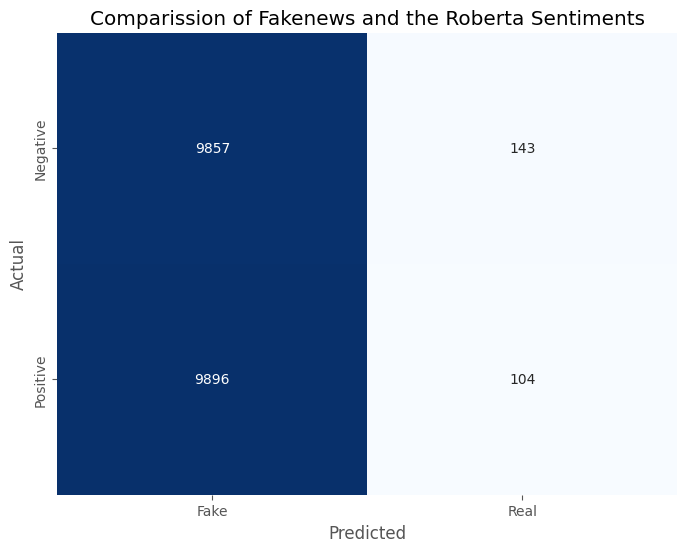

In [38]:
conf_matrix = confusion_matrix(df['isfake'], df['sentiment'])

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Fake', 'Real'], yticklabels=['Negative', 'Positive'])
plt.title('Comparission of Fakenews and the Roberta Sentiments')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [41]:
df

,Unnamed: 0,title,text,subject,date,isfake,label,original,clean,id,roberta_neg,roberta_neu,roberta_pos,predicted_label,sentiment
0,10650,Trump Supporters Terrorize An American Woman ...,Donald Trump s deplorable supporters strike ag...,News,"December 3, 2016",1,fake,Trump Supporters Terrorize An American Woman ...,Trump Supporters Terrorize American Woman Subw...,1,0.930749,0.065000,0.004252,0,0
1,2041,Trump adviser's Russia credentials come under ...,MOSCOW (Reuters) - When Donald Trump named a l...,politicsNews,"August 24, 2016",0,real,Trump adviser's Russia credentials come under ...,Trump adviser 's Russia credentials come scrut...,2,NaN,NaN,NaN,0,0
2,8668,Turkey feels betrayed over EU accession but st...,LONDON (Reuters) - Turkey feels betrayed by so...,worldnews,"September 14, 2017",0,real,Turkey feels betrayed over EU accession but st...,Turkey feels betrayed EU accession wants join ...,3,0.650310,0.335197,0.014493,0,0
3,1114,China newspapers say call with Taiwan's Tsai s...,SHANGHAI (Reuters) - Chinese state media on Mo...,politicsNews,"December 5, 2016",0,real,China newspapers say call with Taiwan's Tsai s...,China newspapers say call Taiwan 's Tsai shows...,4,NaN,NaN,NaN,0,0
4,13902,Sean Hannity Just Openly Threatened Someone O...,Is there some reason people like Donald Trump ...,News,"April 30, 2017",1,fake,Sean Hannity Just Openly Threatened Someone O...,Sean Hannity Openly Threatened Someone Twitter...,5,0.506702,0.450784,0.042515,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,11284,RUSSIAN AMBASSADOR Visited Obama 6 Times Durin...,FLASHBACK: HILLARY CLINTON S STATE DEPARTMENT ...,politics,"Mar 3, 2017",1,fake,RUSSIAN AMBASSADOR Visited Obama 6 Times Durin...,RUSSIAN AMBASSADOR Visited Obama 6 Times Hilla...,19996,NaN,NaN,NaN,0,0
19996,11964,MAJOR Ad Vendor Bans Breitbart For Hate Speec...,You know how Donald Trump has been trying to c...,News,"November 22, 2016",1,fake,MAJOR Ad Vendor Bans Breitbart For Hate Speec...,"MAJOR Ad Vendor Bans Breitbart Hate Speech , T...",19997,NaN,NaN,NaN,0,0
19997,5390,Jordan begins diplomatic offensive ahead of Tr...,AMMAN (Reuters) - Jordan has begun consultatio...,worldnews,"December 3, 2017",0,real,Jordan begins diplomatic offensive ahead of Tr...,Jordan begins diplomatic offensive ahead Trump...,19998,NaN,NaN,NaN,0,0
19998,860,U.S.-Russia tensions over Syria will not 'spir...,WASHINGTON (Reuters) - Tensions between the Un...,politicsNews,"April 11, 2017",0,real,U.S.-Russia tensions over Syria will not 'spir...,U.S.-Russia tensions Syria 'spiral control ' :...,19999,NaN,NaN,NaN,0,0


Text(0.5, 1.0, 'Compund value for both fake and real news')

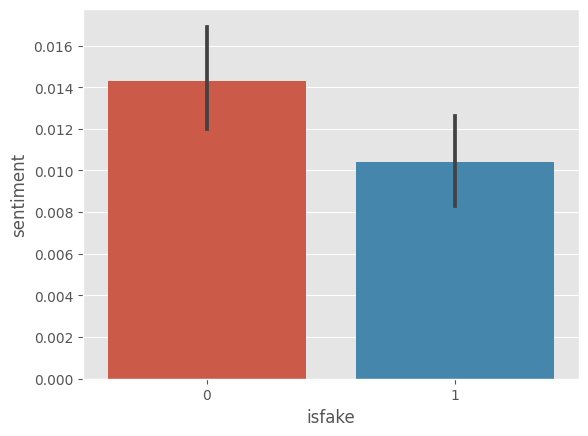

In [40]:
sns.barplot(data=df, x='isfake', y='sentiment')
ax.set_title("Compund value for both fake and real news")

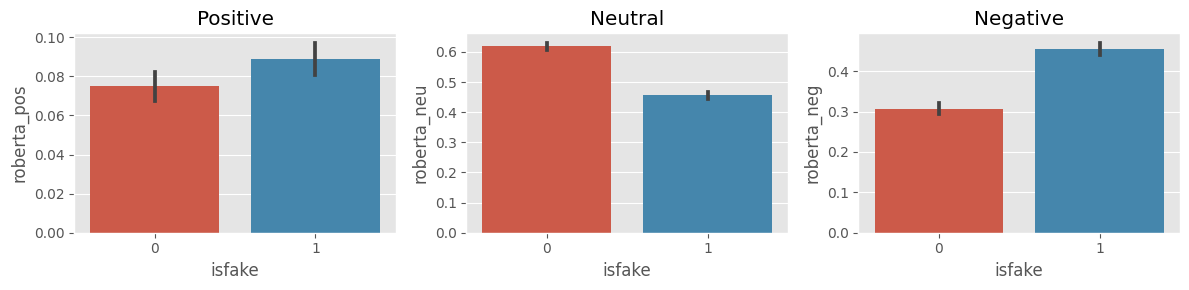

In [42]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=df, x='isfake', y='roberta_pos', ax=axs[0])
sns.barplot(data=df, x='isfake', y='roberta_neu', ax=axs[1])
sns.barplot(data=df, x='isfake', y='roberta_neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

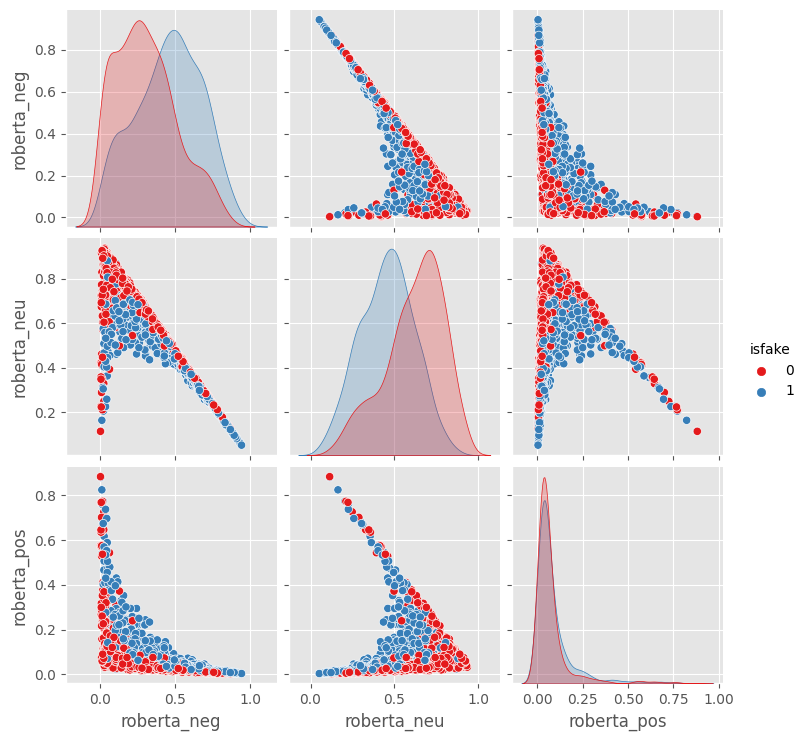

In [44]:
sns.pairplot(data=df,
             vars=['roberta_neg', 'roberta_neu', 'roberta_pos'],
            hue='isfake',
            palette='Set1')
plt.show()

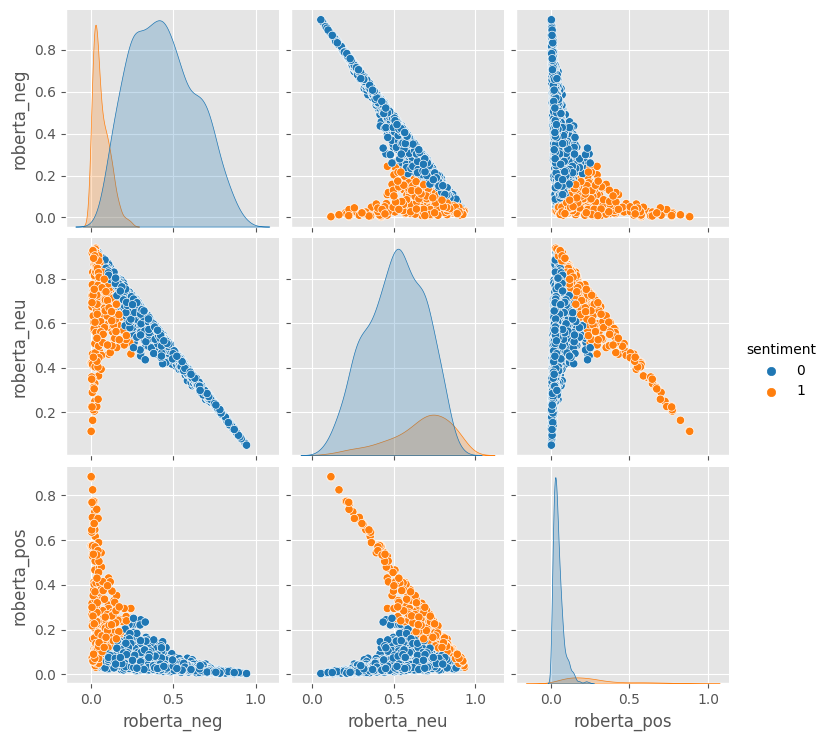

In [46]:
sns.pairplot(data=df,
            vars=['roberta_neg', 'roberta_neu', 'roberta_pos'],
            hue='sentiment',
            palette='tab10')
plt.show()